In [79]:
import torch 
import torch.nn as nn
from torch.utils.data import DataLoader, random_split
from torchvision import datasets,transforms
import matplotlib.pyplot as plt
%matplotlib inline
import cv2
import numpy as np
from glob import glob
from PIL import Image
import torch.optim as optim

In [80]:
device=torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [81]:
size = 128

folder_paths = [
    '/kaggle/input/breast-ultrasound-images-dataset/Dataset_BUSI_with_GT/benign',
    '/kaggle/input/breast-ultrasound-images-dataset/Dataset_BUSI_with_GT/malignant'
]

def load_image(path, size, grayscale=True):
    mode = "L" if grayscale else "RGB"
    img = Image.open(path).convert(mode)
    img = img.resize((size, size))

    img = np.array(img, dtype=np.float32) / 255.0
    img = torch.tensor(img, dtype=torch.float32)

    if grayscale:
        img = img.unsqueeze(0)          # (1,H,W)
    else:
        img = img.permute(2,0,1)        # (C,H,W)

    return img

    

In [82]:
def load_data(folder_paths, size):
    images = []
    masks = []

    prev_image = None
    current_mask = None

    for folder_path in folder_paths:
        file_list = sorted(glob(folder_path + "/*"))

        for fp in file_list:
            img = load_image(fp, size, grayscale=True)

            if "mask" in fp.lower():
                # Merge multiple masks
                if current_mask is None:
                    current_mask = img
                else:
                    current_mask = (current_mask + img > 0.5).float()

            else:
                # If previous image exists → save pair
                if prev_image is not None:
                    images.append(prev_image)
                    masks.append(current_mask)

                prev_image = img
                current_mask = None

        # End of folder → save last image+mask pair
        if prev_image is not None:
            images.append(prev_image)
            masks.append(current_mask)

        prev_image = None
        current_mask = None

    return torch.stack(images), torch.stack(masks)


In [83]:
images, masks = load_data(folder_paths, size)

print("Images shape:", images.shape)
print("Masks shape:", masks.shape)

Images shape: torch.Size([647, 1, 128, 128])
Masks shape: torch.Size([647, 1, 128, 128])


In [84]:
class BUSIDataset(Dataset):
    def __init__(self, images, masks, transform=None):
        self.images = images
        self.masks = masks
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img = self.images[idx]
        mask = self.masks[idx]

        if self.transform:
            img, mask = self.transform(img, mask)

        return img, mask

# Create the dataset object
dataset = BUSIDataset(images, masks)  # images, masks from load_data()


In [85]:
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size

train_dataset, test_dataset = random_split(dataset, [train_size, test_size], 
                                           generator=torch.Generator().manual_seed(42))

train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False)


In [86]:
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
test_loader  = DataLoader(test_dataset, batch_size=8, shuffle=False)


In [87]:
# FIX 2: Correct the conv block for standard U-Net behavior
class conv(nn.Module):
    def __init__(self,in_channels,out_channels):
        super().__init__()
        self.conv=nn.Sequential(
            nn.Conv2d(in_channels,out_channels,kernel_size=3,padding=1),
            nn.ReLU(inplace=True),  # <--- Added ReLU here
            nn.Conv2d(out_channels,out_channels,kernel_size=3,padding=1),
            nn.ReLU(inplace=True)
        )

    def forward(self,x):
        return self.conv(x)

In [88]:
# FIX 1: Use the 'conv' module in the Encoder
class Encoder(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        # Use the reusable 'conv' block
        self.double_conv = conv(in_channels, out_channels)
        self.pool = nn.MaxPool2d(2)

    def forward(self, x):
        # Apply the double convolution first
        x_conv = self.double_conv(x)
        x_pool = self.pool(x_conv)
        return x_conv, x_pool

In [89]:
import torch.functional as F
class Decoder(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        
        # 1. FIX: Set kernel_size=2 and stride=2. Padding is kept at 0.
        # This ensures the output size is exactly double the input size, 
        # matching the skip features from the encoder.
        self.upconv = nn.ConvTranspose2d(in_channels, out_channels, kernel_size=2, stride=2, padding=0)
        
        # 2. Correct Convolution block for concatenated channels
        # Concatenation happens along channel dimension (dim=1)
        self.conv = conv(in_channels=out_channels * 2, out_channels=out_channels) 

    def forward(self, x, skip_features):
        x = self.upconv(x)
        
        # The F.interpolate check is now likely unnecessary, but can be kept 
        # as a safeguard against floating point rounding issues or different
        # max-pooling/convolution padding choices in the encoder.
        if x.size() != skip_features.size():
            # If a mismatch still occurs, resize the skip features to match the upconv output
            skip_features = F.interpolate(skip_features, size=x.shape[2:], mode='bilinear', align_corners=False)
            
        x = torch.cat([x, skip_features], dim=1)
        x = self.conv(x) 
        return x

In [90]:
class Unet(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()

        # Encoder
        self.enc1 = Encoder(in_channels, 64)
        self.enc2 = Encoder(64, 128)
        self.enc3 = Encoder(128, 256)
        self.enc4 = Encoder(256, 512)

        # Bottleneck
        self.bottleneck = conv(512, 1024)

        # Decoder
        self.dec4 = Decoder(1024, 512)
        self.dec3 = Decoder(512, 256)
        self.dec2 = Decoder(256, 128)
        self.dec1 = Decoder(128, 64)

        # Output
        self.out_conv = nn.Conv2d(64, out_channels, kernel_size=1)

    def forward(self, x):
        # Encoder
        s1, p1 = self.enc1(x)
        s2, p2 = self.enc2(p1)
        s3, p3 = self.enc3(p2)
        s4, p4 = self.enc4(p3)

        # Bottleneck
        b = self.bottleneck(p4)

        # Decoder
        d4 = self.dec4(b, s4)
        d3 = self.dec3(d4, s3)
        d2 = self.dec2(d3, s2)
        d1 = self.dec1(d2, s1)

        return torch.sigmoid(self.out_conv(d1))

In [91]:
# Model
model = Unet(in_channels=1, out_channels=1).to(device)

# Loss and optimizer
criterion = nn.BCELoss()           # Binary segmentation
optimizer = optim.Adam(model.parameters(), lr=1e-4)

# Number of epochs
num_epochs = 10


In [92]:
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0

    for imgs, masks in train_loader:
        imgs = imgs.to(device)
        masks = masks.to(device)

        # Forward
        outputs = model(imgs)
        loss = criterion(outputs, masks)

        # Backward
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * imgs.size(0)

    epoch_loss = running_loss / len(train_loader.dataset)
    print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {epoch_loss:.4f}")


Epoch [1/10], Train Loss: 0.4729
Epoch [2/10], Train Loss: 0.3062
Epoch [3/10], Train Loss: 0.2515
Epoch [4/10], Train Loss: 0.2408
Epoch [5/10], Train Loss: 0.2266
Epoch [6/10], Train Loss: 0.2239
Epoch [7/10], Train Loss: 0.2152
Epoch [8/10], Train Loss: 0.2088
Epoch [9/10], Train Loss: 0.2059
Epoch [10/10], Train Loss: 0.1980


In [101]:
# Assuming these variables are defined globally or passed into a function:
# model, criterion, train_loader, test_loader, device, num_epochs, optimizer

train_losses = []
test_losses = []

for epoch in range(num_epochs):
    # 1. Training Phase
    model.train()
    running_loss = 0.0
    
    # ... Training loop contents (optimizer.zero_grad(), loss.backward(), optimizer.step()) ...
    
    # After training loop finishes:
    epoch_train_loss = running_loss / len(train_loader.dataset)
    train_losses.append(epoch_train_loss)
    
    print(f"Epoch [{epoch+1}/{num_epochs}], Training Loss: {epoch_train_loss:.4f}")
    
    # --- 2. Evaluation Phase (Your code block starts here) ---
    
    model.eval()  # Set the model to evaluation mode
    total_loss = 0.0

    print(f"\nEvaluating Test Set after Epoch {epoch+1}...\n")

    with torch.no_grad():
        for i, (imgs, masks) in enumerate(test_loader):
            imgs = imgs.to(device)
            masks = masks.to(device)

            outputs = model(imgs)
            loss = criterion(outputs, masks)

            total_loss += loss.item() * imgs.size(0)

            # Optional: Printing batch loss is fine but can make output very long
            # print(f"Epoch {epoch+1} | Batch {i+1}/{len(test_loader)} | Batch Loss: {loss.item():.4f}")

        avg_loss = total_loss / len(test_loader.dataset)
        test_losses.append(avg_loss) # Store test loss for plotting
        
        print(f"\nEpoch {epoch+1} | Average Test Loss: {avg_loss:.4f}")
        print("="*30)

Epoch [1/10], Training Loss: 0.0000

Evaluating Test Set after Epoch 1...


Epoch 1 | Average Test Loss: 0.2085
Epoch [2/10], Training Loss: 0.0000

Evaluating Test Set after Epoch 2...


Epoch 2 | Average Test Loss: 0.2085
Epoch [3/10], Training Loss: 0.0000

Evaluating Test Set after Epoch 3...


Epoch 3 | Average Test Loss: 0.2085
Epoch [4/10], Training Loss: 0.0000

Evaluating Test Set after Epoch 4...


Epoch 4 | Average Test Loss: 0.2085
Epoch [5/10], Training Loss: 0.0000

Evaluating Test Set after Epoch 5...


Epoch 5 | Average Test Loss: 0.2085
Epoch [6/10], Training Loss: 0.0000

Evaluating Test Set after Epoch 6...


Epoch 6 | Average Test Loss: 0.2085
Epoch [7/10], Training Loss: 0.0000

Evaluating Test Set after Epoch 7...


Epoch 7 | Average Test Loss: 0.2085
Epoch [8/10], Training Loss: 0.0000

Evaluating Test Set after Epoch 8...


Epoch 8 | Average Test Loss: 0.2085
Epoch [9/10], Training Loss: 0.0000

Evaluating Test Set after Epoch 9...


Epoch 9 | Average Test Loss:

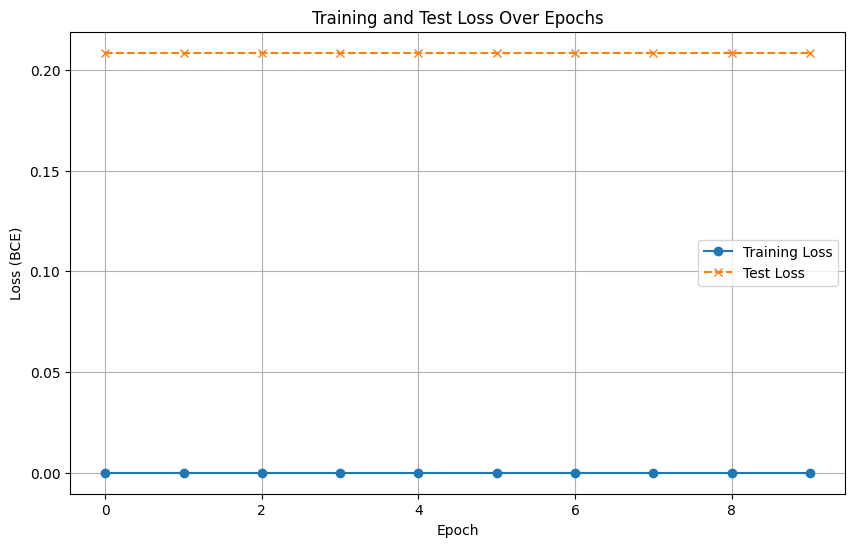

In [106]:
import matplotlib.pyplot as plt

# --- Assume these lists hold the data from your training loop ---
# train_losses = [0.65, 0.58, 0.51, 0.45, 0.39, 0.35, 0.32, 0.30, 0.28, 0.27] 
# test_losses = [0.60, 0.55, 0.50, 0.47, 0.43, 0.40, 0.38, 0.37, 0.36, 0.35]
# -----------------------------------------------------------------

plt.figure(figsize=(10, 6)) # Good practice: Set a figure size for better display

# 1. Plot the Training Loss
# Pass the list of losses as the primary argument (Y-axis data).
# Use the 'label' argument to set the name for the legend.
plt.plot(train_losses, label='Training Loss', marker='o', linestyle='-')

# 2. Plot the Test Loss
plt.plot(test_losses, label='Test Loss', marker='x', linestyle='--')

# 3. Add Legend
# plt.legend() reads the 'label' from the plt.plot calls.
plt.legend() 

# 4. Add Titles and Labels for clarity
plt.title('Training and Test Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss (BCE)')
plt.grid(True)

# 5. Display the plot
plt.show() # This replaces the final plt.plot() which is incorrect for displaying

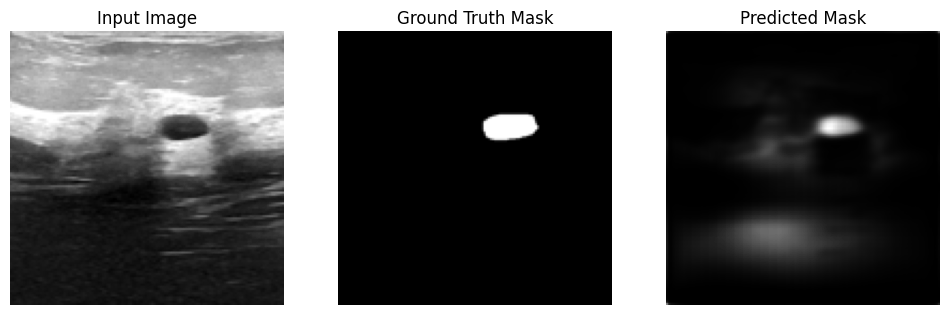

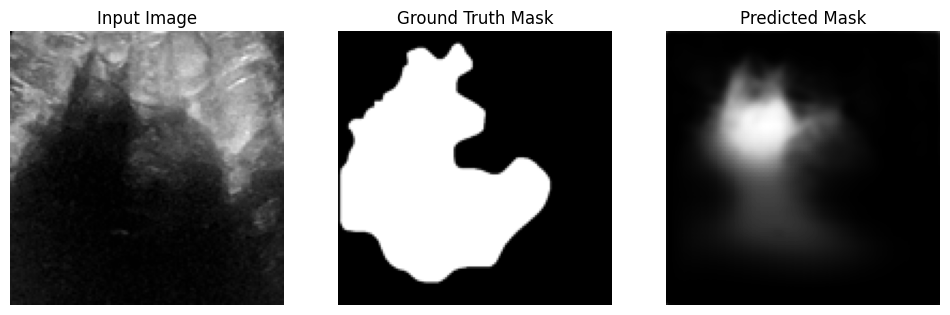

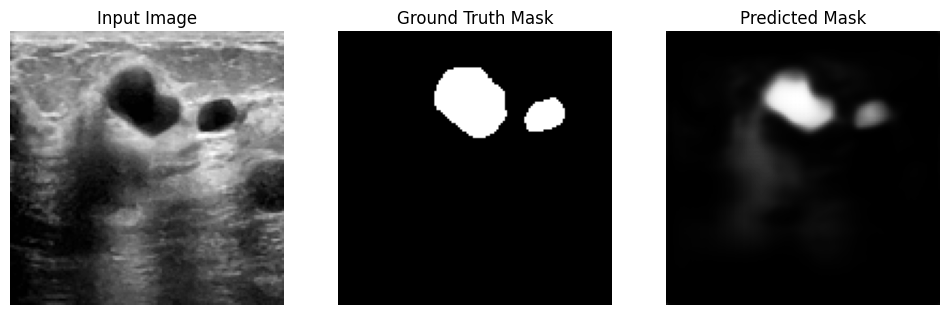

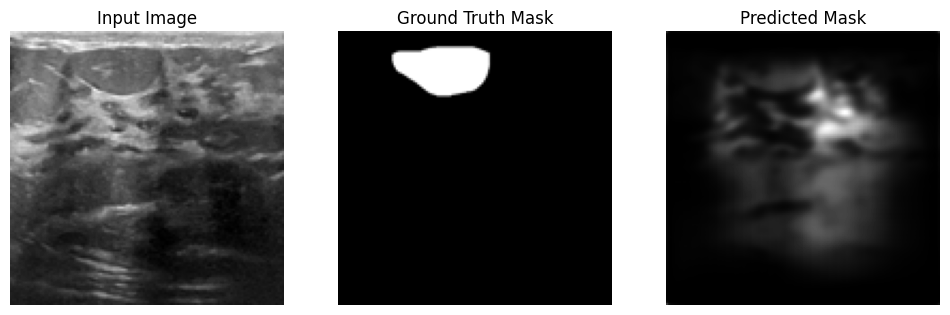

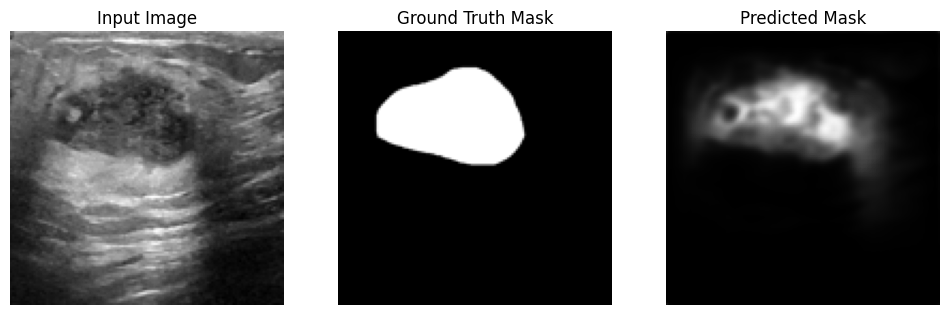

In [109]:
for idx in range(min(5, imgs.size(0))):  # show first 5 images
    plt.figure(figsize=(12,4))
    plt.subplot(1,3,1)
    plt.title("Input Image")
    plt.imshow(imgs[idx,0], cmap='gray')
    plt.axis('off')

    plt.subplot(1,3,2)
    plt.title("Ground Truth Mask")
    plt.imshow(masks[idx,0], cmap='gray')
    plt.axis('off')

    plt.subplot(1,3,3)
    plt.title("Predicted Mask")
    plt.imshow(preds[idx,0].numpy(), cmap='gray')
    plt.axis('off')

    plt.show()

